# Script to scrape IQAir data (daily and hourly)

The first block scrapes hourly and daily data from any IQAir link provided. It saves the data into CSV files. The second block scrapes hourly data and plots it without havingt to save. Could be useful if we ever want to look at hourly timescale, though the data only goes back two days.

In [1]:
import requests
import pandas as pd

def location_data(iqair_url):
    try:
        location = iqair_url.removeprefix("https://www.iqair.com/").strip("/")
        location_id = requests.get(f"https://website-api.airvisual.com/v1/routes/{location}").json()['id']
        measurements_data = requests.get(f"https://website-api.airvisual.com/v1/cities/{location_id}/measurements").json()
        return measurements_data
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def extract_concentration(data_list, mode="hourly"):
    records = []
    for entry in data_list:
        ts = entry.get('ts')
        row = {}

        if mode == "daily" and ts:
            row['date'] = ts.split("T")[0]  # Keep only YYYY-MM-DD
        else:
            row['timestamp'] = ts

        for key, value in entry.items():
            if isinstance(value, dict) and 'concentration' in value:
                row[key] = value['concentration']
        records.append(row)
    return pd.DataFrame(records)

def location_data_to_csv(iqair_url, hourly_csv='hourly.csv', daily_csv='daily.csv'):
    data = location_data(iqair_url)
    if data is None:
        print("No data retrieved.")
        return None, None

    measurements = data.get('measurements', {})
    hourly_data = measurements.get('hourly', [])
    daily_data = measurements.get('daily', [])

    hourly_df = extract_concentration(hourly_data, mode="hourly")
    daily_df = extract_concentration(daily_data, mode="daily")

    hourly_df.to_csv(hourly_csv, index=False)
    daily_df.to_csv(daily_csv, index=False)

    return hourly_df, daily_df

In [2]:
# URL AND FILE NAMES NEED TO BE CHANGED MANUALLY
url = "https://www.iqair.com/mongolia/govi-altay/bayan-ovoo"
hourly, daily = location_data_to_csv(url, "bayan-ovoo_hourly.csv", "bayan-ovoo_daily.csv")
print(hourly.head())
print(daily.head())

                  timestamp  pm25
0  2025-07-22T18:00:00.000Z  62.3
1  2025-07-22T19:00:00.000Z  62.2
2  2025-07-22T20:00:00.000Z  62.2
3  2025-07-22T21:00:00.000Z  62.0
4  2025-07-22T22:00:00.000Z  62.1
         date
0  2025-06-24
1  2025-06-25
2  2025-06-26
3  2025-06-27
4  2025-06-28


# Scrape and plot hourly pollutant data from IQAir

Columns in DataFrame: ['timestamp', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
                  timestamp  pm25  pm10    o3   no2  so2   co
0 2025-07-22 18:00:00+00:00  11.5  24.0  28.0  20.0  7.0  700
1 2025-07-22 19:00:00+00:00  10.0  25.5  21.0  22.5  7.0  700
2 2025-07-22 20:00:00+00:00   9.5  25.0  20.0  22.0  6.5  600
3 2025-07-22 21:00:00+00:00  10.0  23.5  18.0  21.0  7.0  600
4 2025-07-22 22:00:00+00:00  10.0  25.0  15.0  20.0  8.0  650


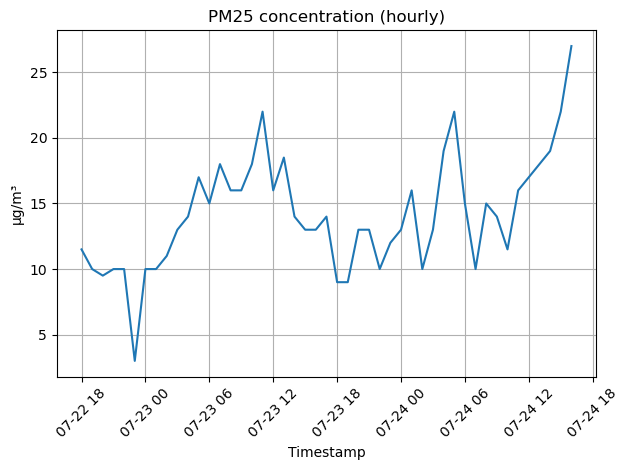

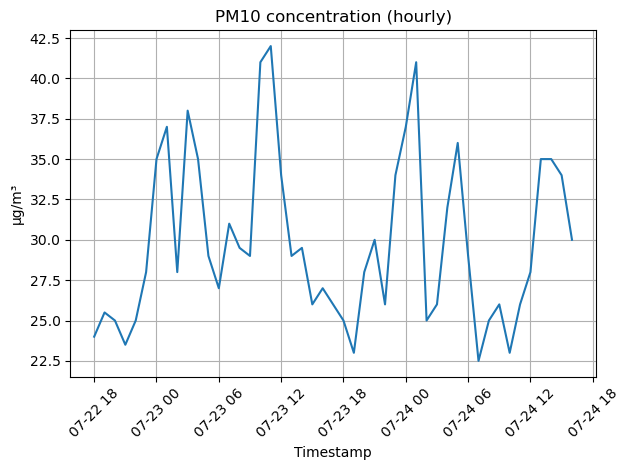

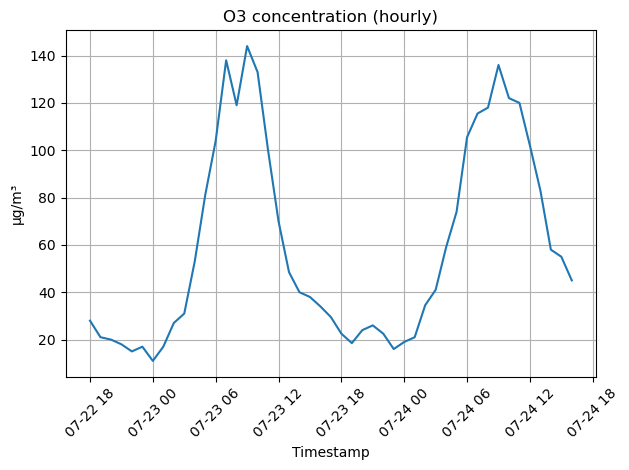

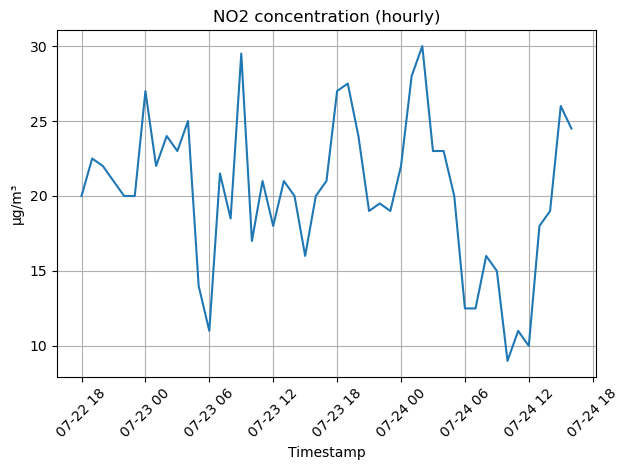

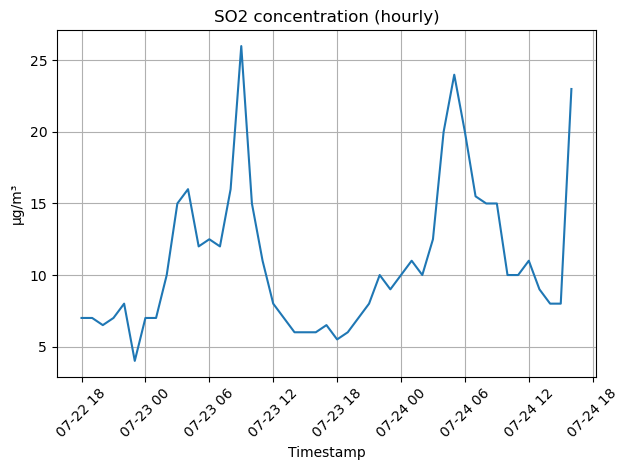

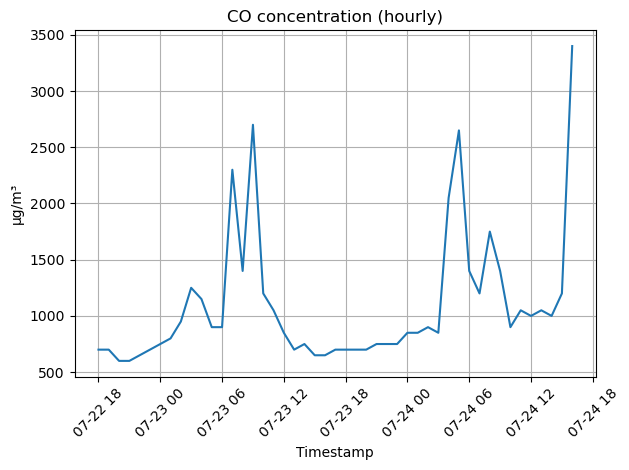

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

iqair_url = "https://www.iqair.com/china/sichuan/panzhihua"   # <-- PUT ANY CITY PAGE HERE
location_path = iqair_url.removeprefix("https://www.iqair.com/").strip("/")

routes_resp = requests.get(f"https://website-api.airvisual.com/v1/routes/{location_path}")
location_id = routes_resp.json()["id"]

meas_resp = requests.get(f"https://website-api.airvisual.com/v1/cities/{location_id}/measurements")
measurements = meas_resp.json()["measurements"]

hourly_raw = measurements["hourly"]
rows = []

for entry in hourly_raw:
    row = {}
    ts = entry.get("ts")
    if ts is None:
        continue
    row["timestamp"] = pd.to_datetime(ts)

    for key, value in entry.items():
        if isinstance(value, dict) and "concentration" in value:
            row[key] = value["concentration"]
    rows.append(row)

hourly_df = pd.DataFrame(rows).sort_values("timestamp")
print("Columns in DataFrame:", hourly_df.columns.tolist())
print(hourly_df.head())

pollutant_cols = [col for col in hourly_df.columns if col != "timestamp"]

for pollutant in pollutant_cols:
    plt.figure()
    plt.plot(hourly_df["timestamp"], hourly_df[pollutant])
    plt.title(f"{pollutant.upper()} concentration (hourly)")
    plt.xlabel("Timestamp")
    plt.ylabel("µg/m³")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
